In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import json
import ast
import seaborn as sns
import os

import lightgbm as lgb
from sklearn.model_selection import train_test_split

from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('ggplot')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

### Loading JSON Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_json('/content/drive/MyDrive/Dayeeta_Project/train.json', \
                     lines=True) # Read the file as a json object per line
test = pd.read_json('/content/drive/MyDrive/Dayeeta_Project/test.json', lines=True)
ss = pd.read_csv('/content/drive/MyDrive/Dayeeta_Project/sample_submission.csv')

print(f'Train shape: {train.shape}, test shape: {test.shape}, \
                    sample submission shape: {ss.shape}')

print('========= train columns ==========')
print([c for c in train.columns])

print('========= test columns ==========')
print([c for c in test.columns])

Train shape: (2400, 19), test shape: (3634, 7),                     sample submission shape: (457953, 6)
========= train columns ==========
['index', 'id', 'sequence', 'structure', 'predicted_loop_type', 'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored', 'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
========= test columns ==========
['index', 'id', 'sequence', 'structure', 'predicted_loop_type', 'seq_length', 'seq_scored']


In [ ]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [ ]:
#test.columns

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'seq_length', 'seq_scored'],
      dtype='object')

In [ ]:
train_data = []
for mol_id in train['id'].unique():
    sample_data = train.loc[train['id'] == mol_id]
    for i in range(68):
        sample_tuple = (sample_data['id'].values[0], sample_data['sequence'].values[0][i],
                        sample_data['structure'].values[0][i], sample_data['predicted_loop_type'].values[0][i],
                        sample_data['reactivity'].values[0][i], sample_data['reactivity_error'].values[0][i],
                        sample_data['deg_Mg_pH10'].values[0][i], sample_data['deg_error_Mg_pH10'].values[0][i],
                        sample_data['deg_pH10'].values[0][i], sample_data['deg_error_pH10'].values[0][i],
                        sample_data['deg_Mg_50C'].values[0][i], sample_data['deg_error_Mg_50C'].values[0][i],
                        sample_data['deg_50C'].values[0][i], sample_data['deg_error_50C'].values[0][i])
        train_data.append(sample_tuple)

In [ ]:
train_data = pd.DataFrame(train_data, columns=['id', 'sequence', 'structure', 'predicted_loop_type', 'reactivity', 'reactivity_error', 'deg_Mg_pH10', 'deg_error_Mg_pH10',
                                  'deg_pH10', 'deg_error_pH10', 'deg_Mg_50C', 'deg_error_Mg_50C', 'deg_50C', 'deg_error_50C'])
train_data.head()

,id,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_Mg_50C,deg_error_Mg_50C,deg_50C,deg_error_50C
0,id_001f94081,G,.,E,0.3297,0.1359,0.7556,0.2613,2.3375,0.2631,0.3581,0.1501,0.6382,0.2167
1,id_001f94081,G,.,E,1.5693,0.2070,2.9830,0.3842,3.5060,0.2860,2.9683,0.2750,3.4773,0.3475
2,id_001f94081,A,.,E,1.1227,0.1633,0.2526,0.1372,0.3008,0.0964,0.2589,0.0947,0.9988,0.1880
3,id_001f94081,A,.,E,0.8686,0.1452,1.3789,0.2531,1.0108,0.1574,1.4552,0.1866,1.3228,0.2124
4,id_001f94081,A,.,E,0.7217,0.1314,0.6376,0.1798,0.2635,0.1000,0.7244,0.1369,0.7877,0.1703


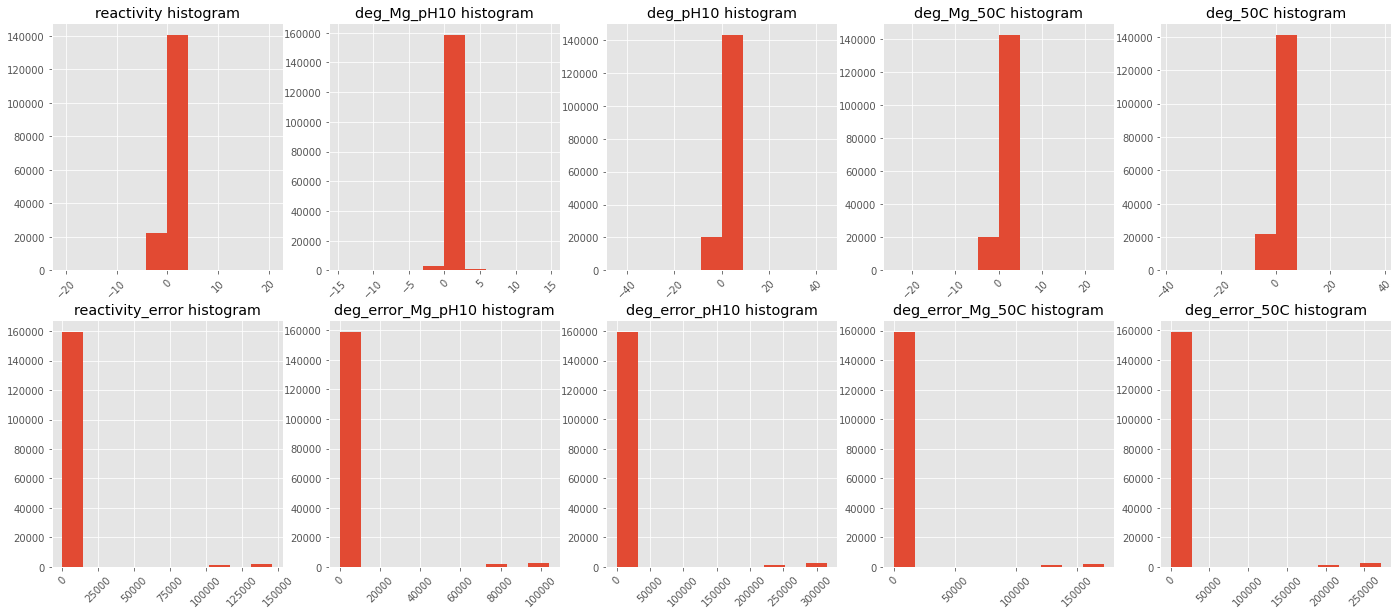

In [ ]:
fig, ax = plt.subplots(figsize = (24, 10))
for i, col in enumerate(['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']):
    plt.subplot(2, 5, i + 1);
    plt.hist(train_data[col])
    plt.title(f'{col} histogram');
    plt.xticks(rotation=45)

In [ ]:
train_data.sort_values('reactivity_error')

,id,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_Mg_50C,deg_error_Mg_50C,deg_50C,deg_error_50C
54443,id_5429cb841,A,),S,0.0000,0.0019,0.0331,0.0173,0.0608,0.0178,0.0072,0.0066,0.0233,0.0135
26991,id_2a3308237,C,),S,0.0016,0.0022,0.0426,0.0066,0.0336,0.0097,0.0481,0.0089,0.0377,0.0115
54421,id_5429cb841,U,(,S,-0.0009,0.0029,0.0250,0.0234,0.0056,0.0101,0.0019,0.0065,0.0071,0.0113
26993,id_2a3308237,A,),S,0.0024,0.0031,0.0950,0.0094,0.0641,0.0131,0.0761,0.0110,0.0547,0.0138
85089,id_8622860d7,U,(,S,0.0000,0.0031,0.0102,0.0204,0.0051,0.0105,0.0115,0.0106,0.0057,0.0117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101750,id_a1719ebbc,G,(,S,0.0000,146151.2250,0.0000,104235.1742,0.0000,314833.5695,0.0000,171525.3217,0.0000,271158.6040
101751,id_a1719ebbc,C,(,S,0.0000,146151.2250,0.0000,104235.1742,0.0000,314833.5695,0.0000,171525.3217,0.0000,271158.6040
101752,id_a1719ebbc,G,(,S,0.0000,146151.2250,0.0000,104235.1742,0.0000,314833.5695,0.0000,171525.3217,0.0000,271158.6040
101754,id_a1719ebbc,G,(,S,0.0000,146151.2250,0.0000,104235.1742,0.0000,314833.5695,0.0000,171525.3217,0.0000,271158.6040


In [ ]:
train.loc[train['id'] == 'id_a1719ebbc']

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
1496,1496,id_a1719ebbc,GGAAACGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCCGCGCGCG...,.....((((((((((((((((((((((((((((((...))))))))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSHHHSSSSSSSS...,0.0,0,107,68,"[146151.225, 146151.225, 146151.225, 146151.22...","[104235.1742, 104235.1742, 104235.1742, 104235...","[314833.5695, 314833.5695, 314833.5695, 314833...","[171525.3217, 171525.3217, 171525.3217, 171525...","[271158.604, 271158.604, 271158.604, 271158.60...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


What are these huge errors???

In [ ]:
test_data = []
for mol_id in test['id'].unique():
    sample_data = test.loc[test['id'] == mol_id]
    for i in range(sample_data['seq_scored'].values[0]):
        sample_tuple = (sample_data['id'].values[0] + f'_{i}', 
                        sample_data['sequence'].values[0][i],
                        sample_data['structure'].values[0][i], 
                        sample_data['predicted_loop_type'].values[0][i])
        test_data.append(sample_tuple)

In [ ]:
test_data = pd.DataFrame(test_data, columns=['id', 'sequence', 'structure', 'predicted_loop_type'])
test_data.head()

,id,sequence,structure,predicted_loop_type
0,id_00073f8be_0,G,.,E
1,id_00073f8be_1,G,.,E
2,id_00073f8be_2,A,.,E
3,id_00073f8be_3,A,.,E
4,id_00073f8be_4,A,.,E


The numpy data in the *bpps* folder are basically Base Pairing Probability Matrix files.

A base-pairing probability matrix (BPPM) stores the probabilities for every possible base pair in an RNA sequence and has been used in many algorithms in RNA informatics (e.g., RNA secondary structure prediction and motif search). 

In this study, we propose a novel algorithm to perform iterative updates of a given BPPM, satisfying marginal probability constraints that are (approximately) given by recently developed biochemical experiments, such as SHAPE, PAR, and FragSeq. The method is easily implemented and is applicable to common models for RNA secondary structures, such as energy-based or machine-learning–based models. 

In [ ]:
bpps_files = os.listdir('/content/drive/MyDrive/Dayeeta_Project/bpps/')
example_bpps = np.load(f'/content/drive/MyDrive/Dayeeta_Project/bpps/{bpps_files[0]}')
print('bpps file shape:', example_bpps.shape)

bpps file shape: (130, 130)


Lets plot this data for 25 examples.

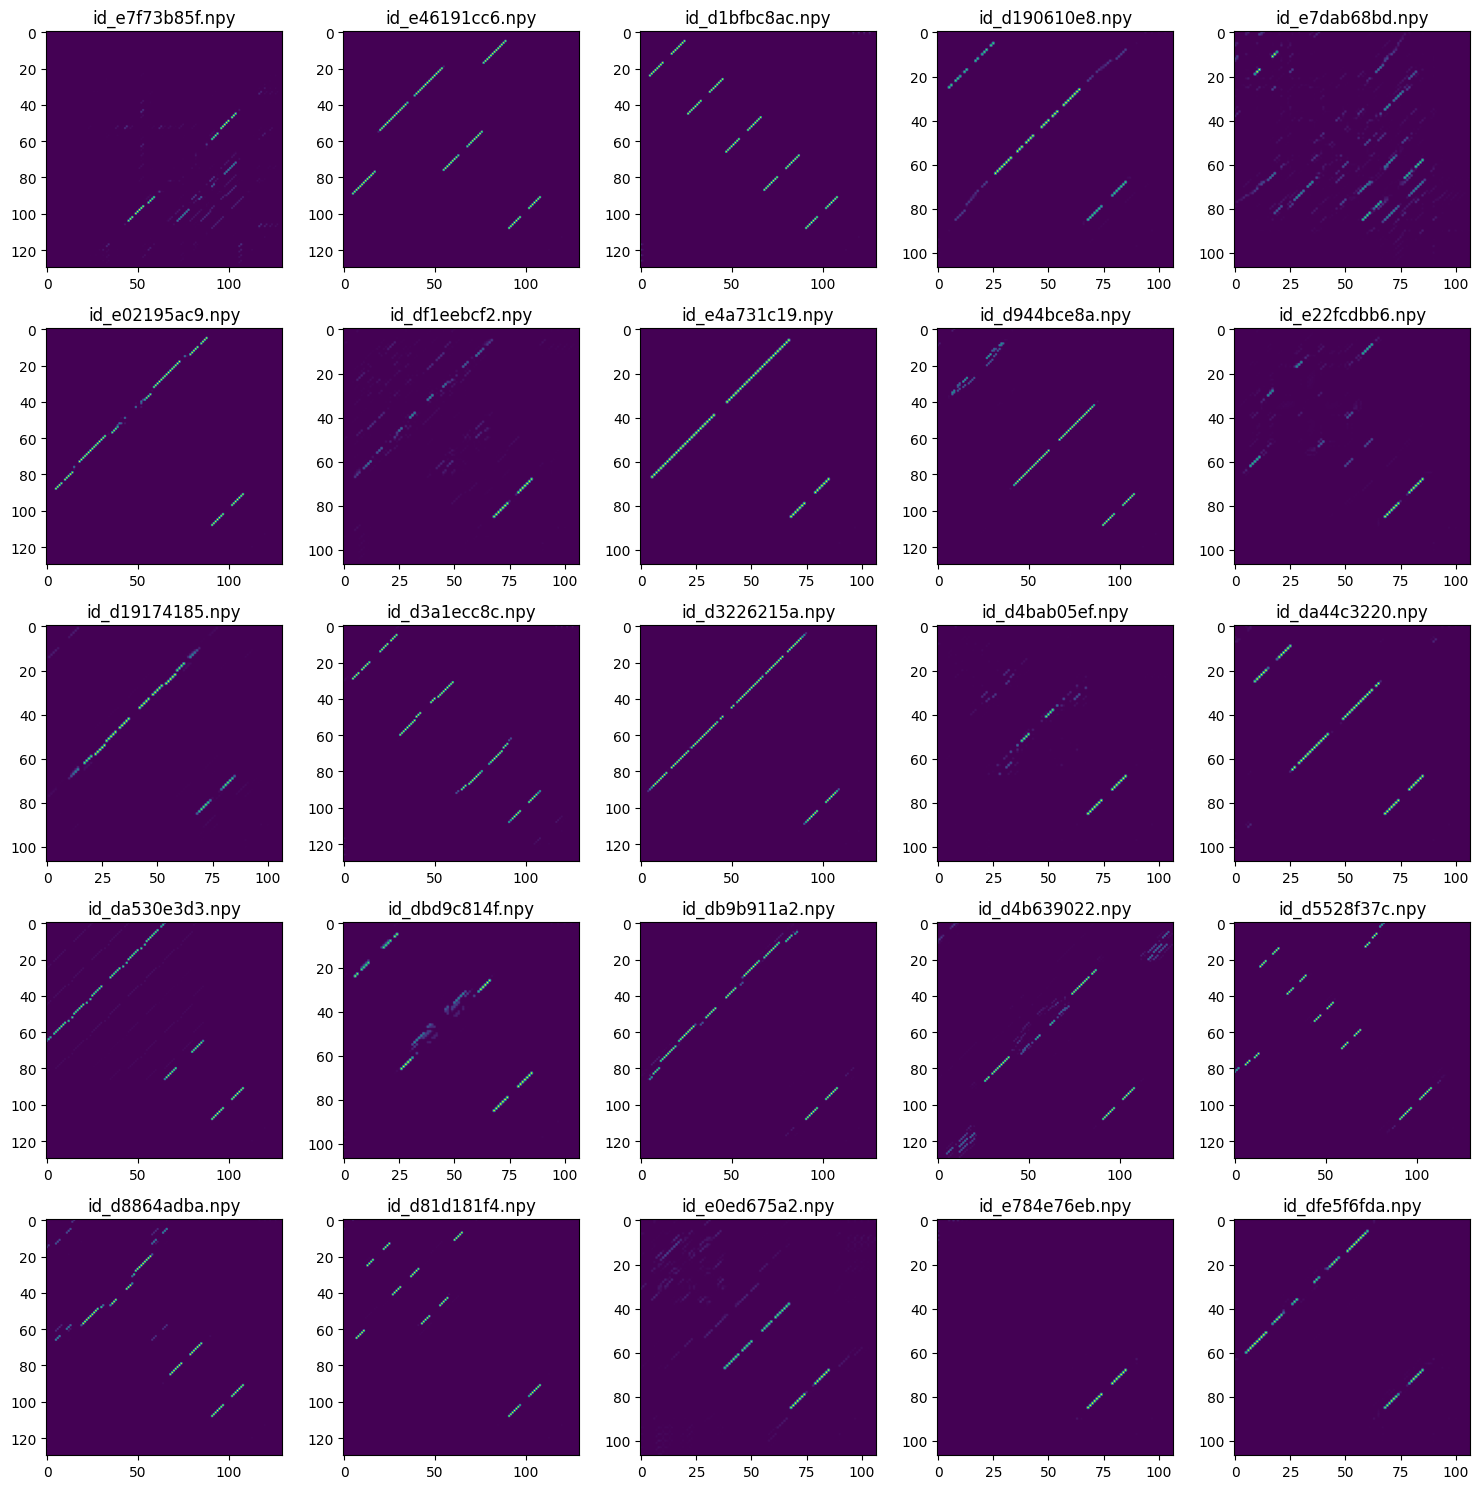

In [ ]:
plt.style.use('default')
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs = axs.flatten()
for i, f in enumerate(bpps_files):
    if i == 25:
        break
    example_bpps = np.load(f'/content/drive/MyDrive/Dayeeta_Project/bpps/{f}')
    axs[i].imshow(example_bpps)
    axs[i].set_title(f)
plt.tight_layout()
plt.show()

### Sample Submission

In [ ]:
ss.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


### Reactivity column

In the data description we are told:

- reactivity - (1x68 vector in train/test, 1x91 in final scoring) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likely secondary structure of the RNA sample.

In [ ]:
train['reactivity'].head()

0    [0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...
1    [0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....
2    [0.44820000000000004, 1.4822, 1.1819, 0.743400...
3    [0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....
4    [0.8267, 2.6577, 2.8481, 0.40090000000000003, ...
Name: reactivity, dtype: object

In [ ]:
print('===== Example Train Reacivity ======')
print([round(r, 2) for r in train['reactivity'][0]])

===== Example Train Reacivity ======
[0.33, 1.57, 1.12, 0.87, 0.72, 0.44, 0.26, 0.34, 0.22, 0.36, 0.95, 1.41, 1.69, 1.25, 1.19, 0.69, 0.47, 0.18, 0.06, 0.22, 0.08, 0.82, 0.76, 0.11, 0.26, 0.09, 0.16, 0.77, 0.16, 0.5, 1.04, 0.48, 0.56, 0.91, 1.01, 1.05, 1.04, 0.45, 0.21, 0.05, 0.08, 0.06, 0.15, 0.09, 0.51, 1.07, 0.32, 0.07, 0.02, 0.01, 0.2, 0.5, 1.06, 0.64, 0.68, 0.36, 0.17, 0.14, 0.16, 0.54, 0.68, 0.43, 0.05, 0.07, 0.14, 0.29, 0.24, 0.57]


### deg_Mg_pH10 column

- deg_Mg_pH10 - (1x68 vector in train/test, 1x91 in final scoring) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10).

In [ ]:
print('===== Example Train deg_Mg_pH10 value ======')
print([round(r, 2) for r in train['deg_Mg_pH10'][0]])

===== Example Train deg_Mg_pH10 value ======
[0.76, 2.98, 0.25, 1.38, 0.64, 0.33, 0.68, 0.75, 0.21, 0.89, 0.99, 0.87, 1.74, 1.38, 0.77, 0.72, 0.72, 0.41, 0.26, 0.36, 0.07, 0.48, 0.28, 0.49, 0.44, 0.33, 0.09, 0.42, 0.23, 0.41, 0.52, 0.27, 0.32, 0.91, 0.88, 0.9, 0.73, 0.48, 0.12, 0.2, 0.18, 0.13, 0.27, 0.88, 0.88, 0.87, 0.51, 0.35, 0.04, 0.12, 0.46, 0.32, 2.12, 0.37, 0.35, 0.27, 0.32, 0.18, 0.33, 0.47, 0.61, 0.31, 0.14, 0.13, 0.16, 0.33, 0.65, 0.69]


### deg_Mg_50C column

- deg_Mg_50C - (1x68 vector in train/test, 1x91 in final scoring) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).

In [ ]:
print('===== Example Train deg_Mg_50C value ======')
print([round(r, 2) for r in train['deg_Mg_50C'][0]])

===== Example Train deg_Mg_50C value ======
[0.36, 2.97, 0.26, 1.46, 0.72, 0.5, 0.38, 0.91, 0.17, 1.06, 1.13, 0.75, 1.9, 1.1, 0.73, 0.76, 0.7, 0.43, 0.24, 0.4, 0.04, 0.34, 0.29, 0.4, 0.31, 0.31, 0.24, 0.2, 0.37, 0.45, 0.63, 0.21, 0.62, 1.06, 0.87, 0.92, 0.85, 0.63, 0.18, 0.4, 0.22, 0.15, 0.15, 0.66, 0.57, 0.46, 0.27, 0.28, 0.03, 0.04, 0.23, 0.29, 1.75, 0.32, 0.3, 0.2, 0.23, 0.2, 0.41, 0.55, 0.38, 0.34, 0.19, 0.26, 0.27, 0.48, 0.7, 0.43]


### signal_to_noise feature

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


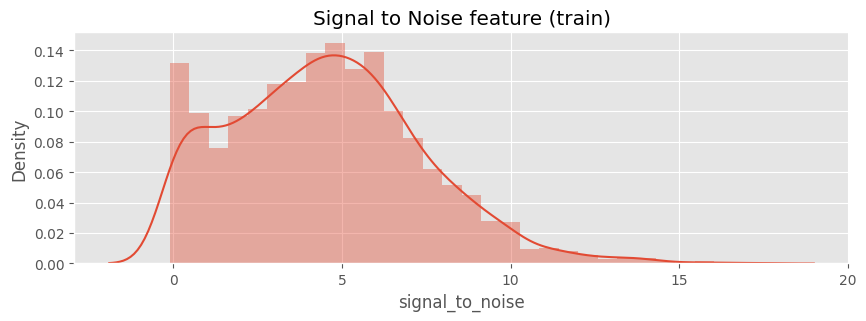

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 3))
ax = sns.distplot(train['signal_to_noise'])
ax.set_title('Signal to Noise feature (train)')
plt.show()

### seq_length

- Train data consists of only 107 sequence length. 
- Test data contains mostly 130 sequence lengths.

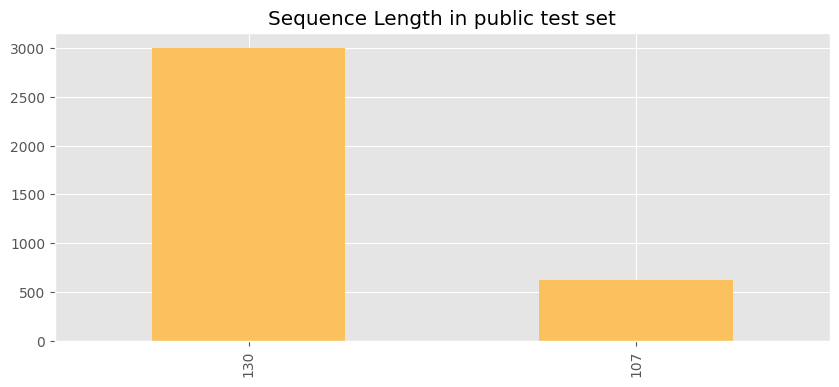

In [ ]:
test['seq_length'].value_counts() \
    .plot(kind='bar', figsize=(10, 4),
          color=color_pal[4],
         title='Sequence Length in public test set')
plt.show()

### Baseline Submission [0.47840 LB]

#### Predict the average value for each target column

Lets first calculate the average value for the target columns. And then create a 91 length vector as a baseline submission.

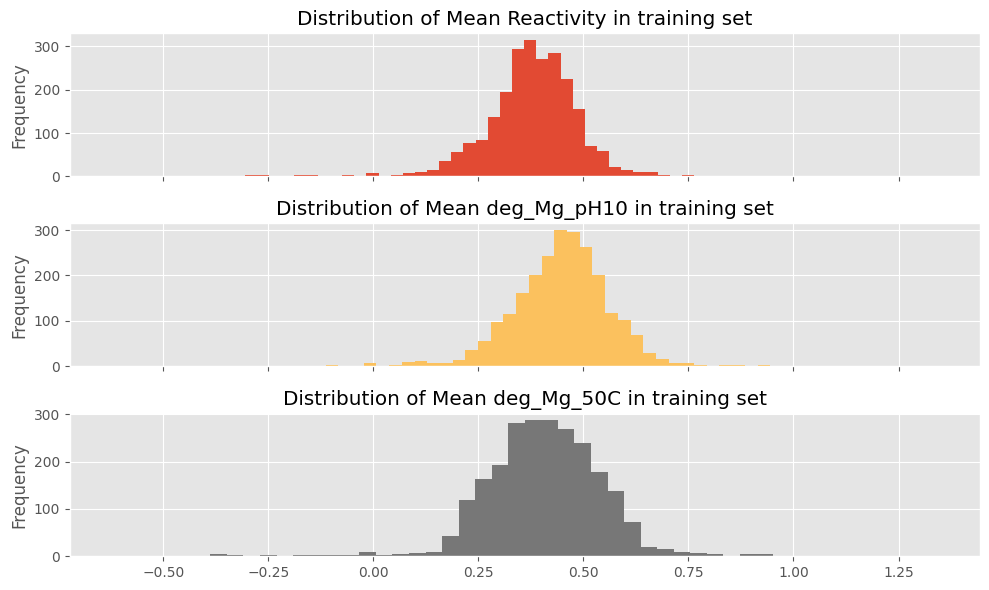

In [ ]:
fig, axs = plt.subplots(3, 1,
                        figsize=(10, 6),
                        sharex=True)
axs = axs.flatten()
train['mean_reactivity'] = train['reactivity'].apply(lambda x: np.mean(x))
train['mean_deg_Mg_pH10'] = train['deg_Mg_pH10'].apply(lambda x: np.mean(x))
train['mean_deg_Mg_50C'] = train['deg_Mg_50C'].apply(lambda x: np.mean(x))

train['mean_reactivity'] \
    .plot(kind='hist',
          bins=50,
          color=color_pal[0],
          title='Distribution of Mean Reactivity in training set',
         ax=axs[0])
train['mean_deg_Mg_pH10'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[1],
          color=color_pal[4],
          title='Distribution of Mean deg_Mg_pH10 in training set')
train['mean_deg_Mg_50C'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[2],
          color=color_pal[3],
          title='Distribution of Mean deg_Mg_50C in training set')
plt.tight_layout()
plt.show()

#### Fill in predictions with the mean value

In [ ]:
mean_react = train['mean_reactivity'].mean()
mean_deg_Mg_pH10 = train['mean_deg_Mg_pH10'].mean()
mean_deg_Mg_50C = train['mean_deg_Mg_50C'].mean()

ss['reactivity'] = mean_react
ss['deg_Mg_pH10'] = mean_deg_Mg_pH10
ss['deg_Mg_50C'] = mean_deg_Mg_50C

ss.to_csv('submission.csv', index=False)
ss.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.374922,0.446303,0.0,0.40703,0.0
1,id_00073f8be_1,0.374922,0.446303,0.0,0.40703,0.0
2,id_00073f8be_2,0.374922,0.446303,0.0,0.40703,0.0
3,id_00073f8be_3,0.374922,0.446303,0.0,0.40703,0.0
4,id_00073f8be_4,0.374922,0.446303,0.0,0.40703,0.0


### Plot the Targets for Each Training Example

First we need to split the list of 68 values for each target into their own columns. Then we can plot.

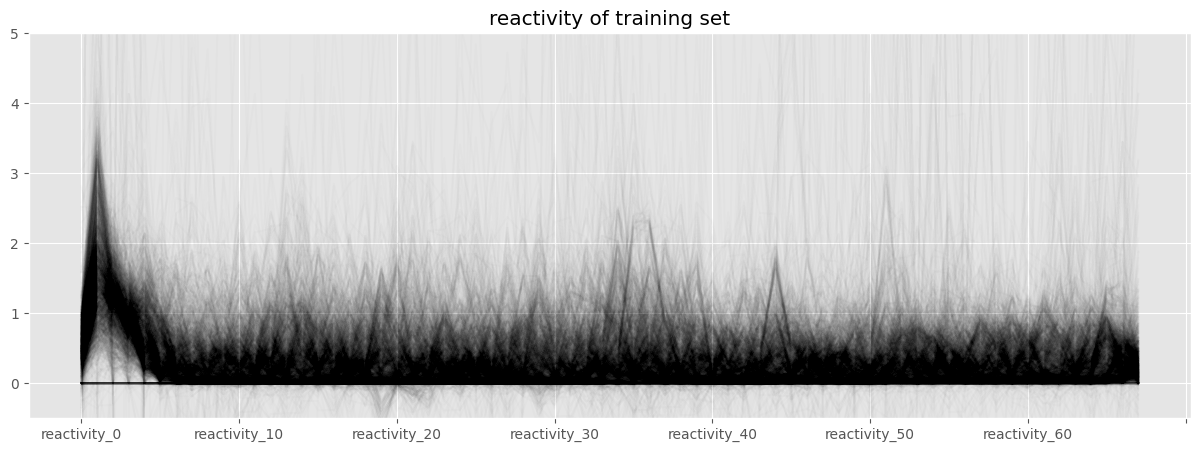

In [ ]:
# Split the 68 Reactivity values each into it's own column
for n in range(68):
    train[f'reactivity_{n}'] = train['reactivity'].apply(lambda x: x[n])
    
REACTIVITY_COLS = [r for r in train.columns if 'reactivity_' in r and 'error' not in r]

ax = train.set_index('id')[REACTIVITY_COLS] \
    .T \
    .plot(color='black',
          alpha=0.01,
          ylim=(-0.5, 5),
          title='reactivity of training set',
          figsize=(15, 5))
ax.get_legend().remove()

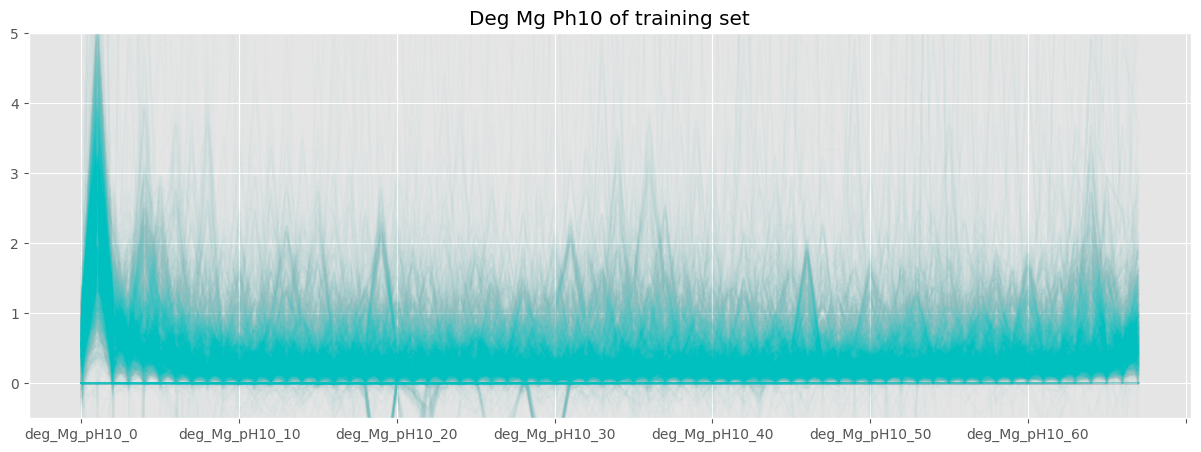

In [ ]:
for n in range(68):
    train[f'deg_Mg_pH10_{n}'] = train['deg_Mg_pH10'].apply(lambda x: x[n])
    
DEG_MG_PH10_COLS = [r for r in train.columns if 'deg_Mg_pH10_' in r and 'error' not in r]

ax = train.set_index('id')[DEG_MG_PH10_COLS] \
    .T \
    .plot(color='c',
          alpha=0.01,
          ylim=(-0.5, 5),
          title='Deg Mg Ph10 of training set',
          figsize=(15, 5))
ax.get_legend().remove()

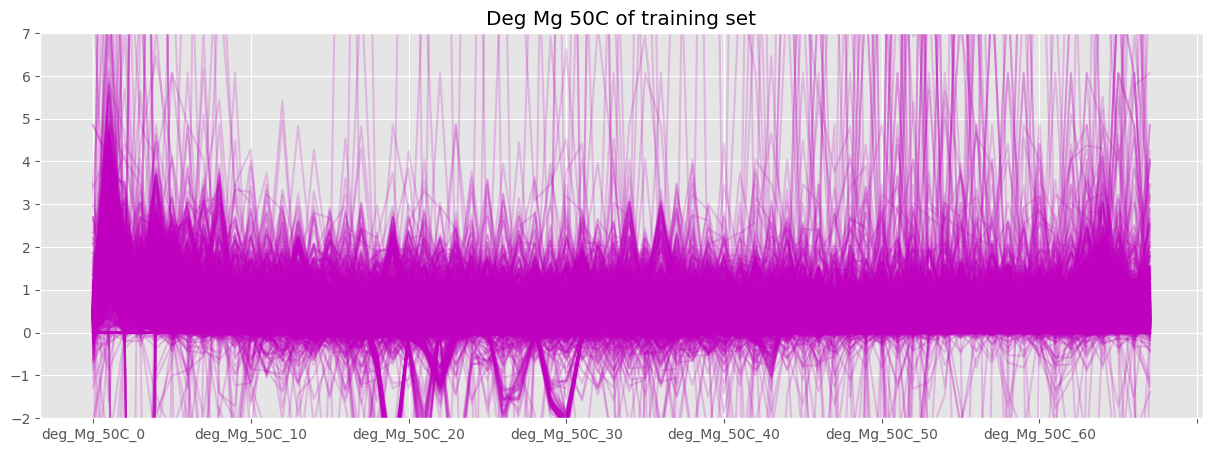

In [ ]:
for n in range(68):
    train[f'deg_Mg_50C_{n}'] = train['deg_Mg_50C'].apply(lambda x: x[n])
    
DEG_MG_50C_COLS = [r for r in train.columns if 'deg_Mg_50C_' in r and 'error' not in r]

ax = train.set_index('id')[DEG_MG_50C_COLS] \
    .T \
    .plot(color='m',
          alpha=0.2,
          ylim=(-2, 7),
          title='Deg Mg 50C of training set',
          figsize=(15, 5)
         )
ax.get_legend().remove()

### Relationship between targets

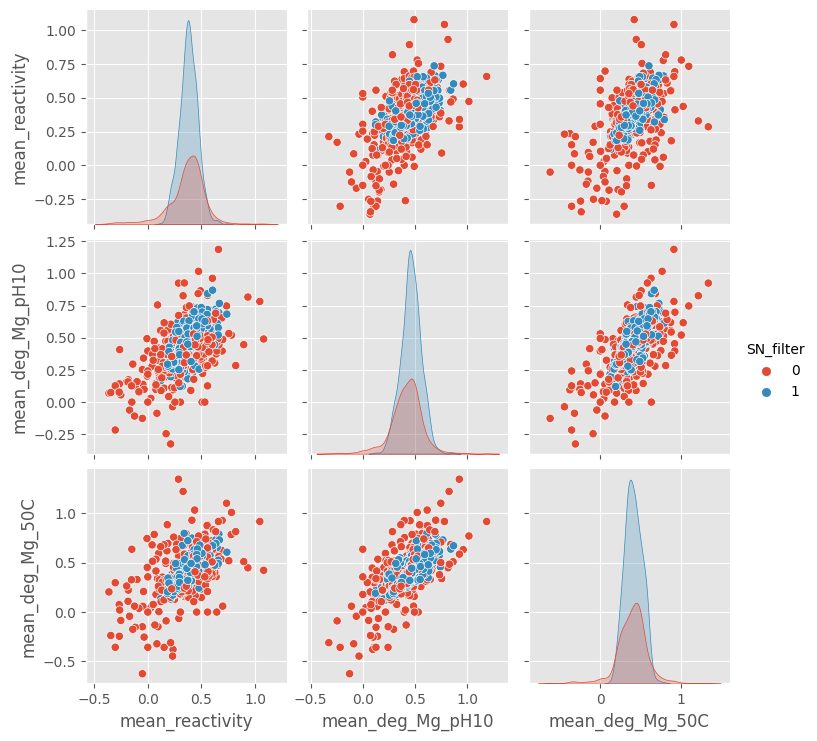

In [ ]:
sns.pairplot(data=train,
             vars=['mean_reactivity',
                   'mean_deg_Mg_pH10',
                    'mean_deg_Mg_50C'],
            hue='SN_filter')
plt.show()

### Simple Baseline Using Simple LightGBM

This model still predicts the same value for each id in the test set, but the predicted value is based off of the sequence data.

In [ ]:
# Expand Sequence Features
for n in range(107):
    train[f'sequence_{n}'] = train['sequence'].apply(lambda x: x[n]).astype('category')
    test[f'sequence_{n}'] = test['sequence'].apply(lambda x: x[n]).astype('category')

SEQUENCE_COLS = [c for c in train.columns if 'sequence_' in c]

for target in ['reactivity','deg_Mg_pH10','deg_Mg_50C']:

    X = train[SEQUENCE_COLS]
    y = train[f'mean_{target}']
    X_test = test[SEQUENCE_COLS]

    X_train, X_val, y_train, y_val = train_test_split(X, y)

    reg = lgb.LGBMRegressor(n_estimators=1000)
    reg.fit(X_train, y_train,
            eval_set=(X_val, y_val),
            early_stopping_rounds=100,
            verbose=100)

    test[f'mean_{target}_pred'] = reg.predict(X_test)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.00884656
Early stopping, best iteration is:
[80]	valid_0's l2: 0.00878687
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.00668729
Early stopping, best iteration is:
[62]	valid_0's l2: 0.00660616
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.0132403
Early stopping, best iteration is:
[49]	valid_0's l2: 0.0129683


In [ ]:
ss['id_seqpos'].head()

0    id_00073f8be_0
1    id_00073f8be_1
2    id_00073f8be_2
3    id_00073f8be_3
4    id_00073f8be_4
Name: id_seqpos, dtype: object

### Map mean predictions to test

In [ ]:
ss['id'] = 'id_' + ss['id_seqpos'].str.split('_', expand=True)[1]

# Merge my predicted average values
ss_new = ss. \
    drop(['reactivity','deg_Mg_pH10','deg_Mg_50C'], axis=1) \
    .merge(test[['id',
               'mean_reactivity_pred',
               'mean_deg_Mg_pH10_pred',
               'mean_deg_Mg_50C_pred']] \
               .rename(columns={'mean_reactivity_pred' : 'reactivity',
                                'mean_deg_Mg_pH10_pred': 'deg_Mg_pH10',
                                'mean_deg_Mg_50C_pred' : 'deg_Mg_50C'}
                      ),
         on='id',
        validate='m:1')

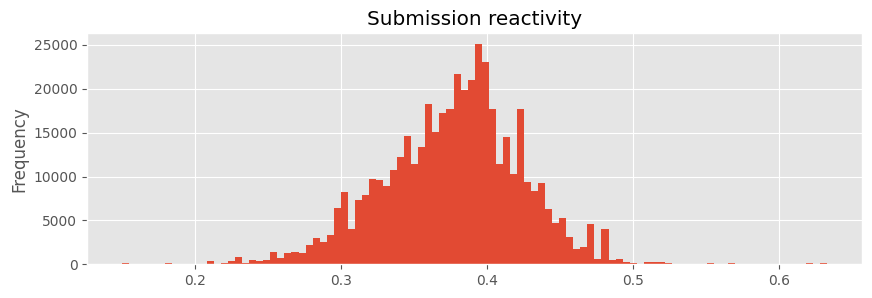

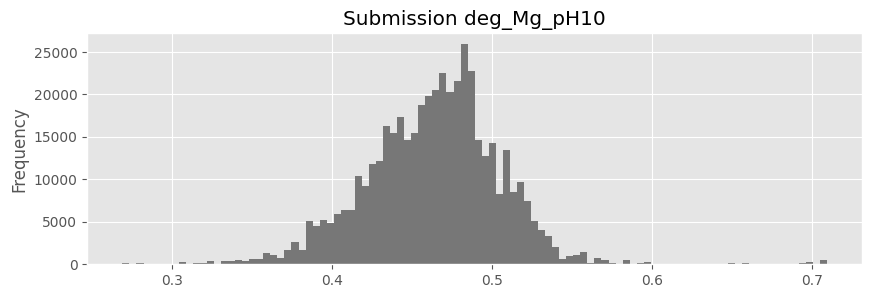

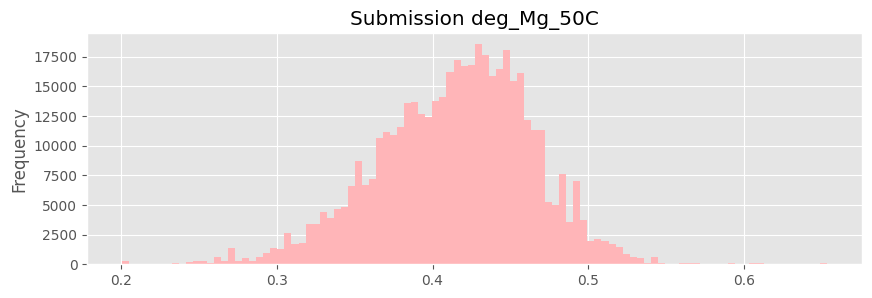

In [ ]:
TARGETS = ['reactivity','deg_Mg_pH10','deg_Mg_50C']
for i, t in enumerate(TARGETS):
    ss_new[t].plot(kind='hist',
                   figsize=(10, 3),
                   bins=100,
                   color=color_pal[i*3],
                   title=f'Submission {t}')
    plt.show()

In [ ]:
ss_new.sample(10)

,id_seqpos,deg_pH10,deg_50C,id,reactivity,deg_Mg_pH10,deg_Mg_50C
382149,id_d1659e148_80,0.0,0.0,id_d1659e148,0.304275,0.467533,0.420240
321451,id_b03b10d69_3,0.0,0.0,id_b03b10d69,0.411172,0.505379,0.408968
136549,id_48c920ead_60,0.0,0.0,id_48c920ead,0.301824,0.434632,0.373428
240080,id_820fe2166_81,0.0,0.0,id_820fe2166,0.344956,0.480637,0.338257
46476,id_17761aa7c_93,0.0,0.0,id_17761aa7c,0.375289,0.446307,0.414556
451444,id_fb3833ddb_21,0.0,0.0,id_fb3833ddb,0.391141,0.469807,0.413767
386335,id_d40628c39_114,0.0,0.0,id_d40628c39,0.374688,0.450571,0.397500
234953,id_7f18e63d3_54,0.0,0.0,id_7f18e63d3,0.436144,0.464665,0.456850
439191,id_f4713355d_56,0.0,0.0,id_f4713355d,0.424768,0.411420,0.401049
132786,id_46ad44932_82,0.0,0.0,id_46ad44932,0.367148,0.465414,0.470316


In [ ]:
# Make Submission
ss = pd.read_csv('/content/drive/MyDrive/Dayeeta_Project/sample_submission.csv')
ss_new[ss.columns].to_csv('submission_lgbm_v1.csv', index=False)

### Improve Baseline by adding: **structure** and **predicted_loop_type** features [0.47520 LB]

Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's l2: 0.00926754
[2000]	valid_0's l2: 0.00792315
[3000]	valid_0's l2: 0.00746464
[4000]	valid_0's l2: 0.00724911
[5000]	valid_0's l2: 0.00717011
[6000]	valid_0's l2: 0.00711846
[7000]	valid_0's l2: 0.00708598
Early stopping, best iteration is:
[7487]	valid_0's l2: 0.0070741
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's l2: 0.00967839
[2000]	valid_0's l2: 0.00870289
[3000]	valid_0's l2: 0.00840445
[4000]	valid_0's l2: 0.00825091
[5000]	valid_0's l2: 0.00820116
Early stopping, best iteration is:
[5603]	valid_0's l2: 0.0081689
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's l2: 0.0142335
[2000]	valid_0's l2: 0.0126364
[3000]	valid_0's l2: 0.0120255
[4000]	valid_0's l2: 0.0116652
[5000]	valid_0's l2: 0.0114355
[6000]	valid_0's l2: 0.0113147
[7000]	valid_0's l2: 0.0112607
Early stopping, best iteration is:
[6982]	valid_0's l2: 0.01126


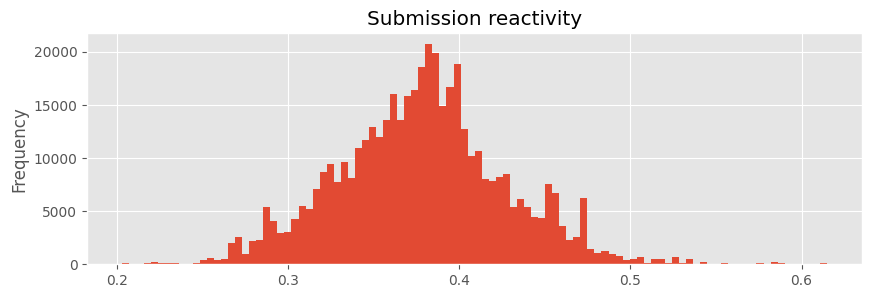

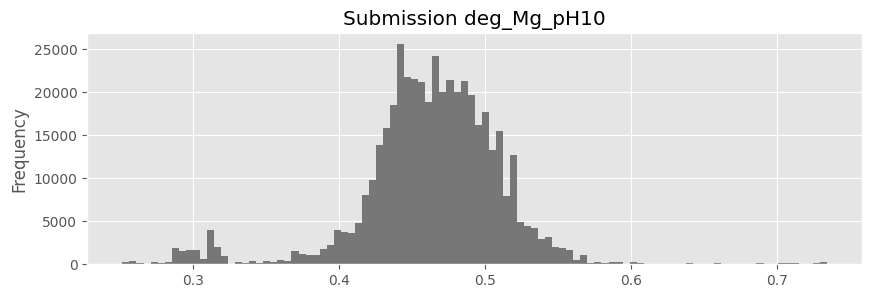

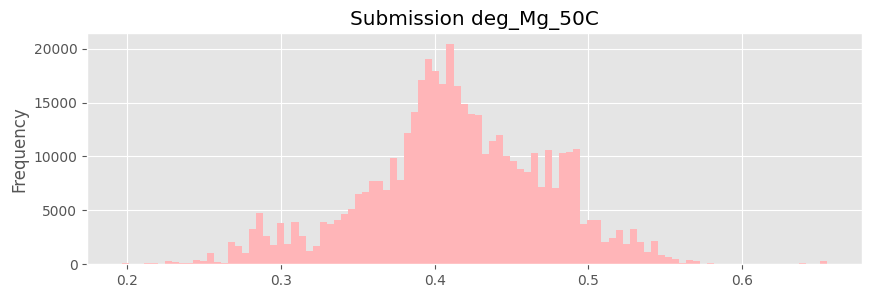

In [ ]:
# Expand Sequence Features
for n in range(107):
    train[f'structure_{n}'] = train['structure'].apply(lambda x: x[n]).astype('category')
    test[f'structure_{n}'] = test['structure'].apply(lambda x: x[n]).astype('category')
    train[f'predicted_loop_type_{n}'] = train['predicted_loop_type'].apply(lambda x: x[n]).astype('category')
    test[f'predicted_loop_type_{n}'] = test['predicted_loop_type'].apply(lambda x: x[n]).astype('category')
    train[f'sequence_{n}'] = train['sequence'].apply(lambda x: x[n]).astype('category')
    test[f'sequence_{n}'] = test['sequence'].apply(lambda x: x[n]).astype('category')

SEQUENCE_COLS = [c for c in train.columns if 'sequence_' in c]
STRUCTURE_COLS = [c for c in train.columns if 'structure_' in c]
PLT_COLS = [c for c in train.columns if 'predicted_loop_type_' in c]

for target in ['reactivity','deg_Mg_pH10','deg_Mg_50C']:

    X = train[SEQUENCE_COLS + STRUCTURE_COLS + PLT_COLS]
    y = train[f'mean_{target}']
    X_test = test[SEQUENCE_COLS + STRUCTURE_COLS + PLT_COLS]

    X_train, X_val, y_train, y_val = train_test_split(X, y)

    reg = lgb.LGBMRegressor(n_estimators=10000,
                            learning_rate=0.001,
                            feature_fraction=0.8)
    reg.fit(X_train, y_train,
            eval_set=(X_val, y_val),
           early_stopping_rounds=100,
           verbose=1000)

    test[f'mean_{target}_pred'] = reg.predict(X_test)
    
ss['id'] = 'id_' + ss['id_seqpos'].str.split('_', expand=True)[1]

# Merge my predicted average values
ss_new = ss. \
    drop(['reactivity','deg_Mg_pH10','deg_Mg_50C'], axis=1) \
    .merge(test[['id',
               'mean_reactivity_pred',
               'mean_deg_Mg_pH10_pred',
               'mean_deg_Mg_50C_pred']] \
               .rename(columns={'mean_reactivity_pred' : 'reactivity',
                                'mean_deg_Mg_pH10_pred': 'deg_Mg_pH10',
                                'mean_deg_Mg_50C_pred' : 'deg_Mg_50C'}
                      ),
         on='id',
        validate='m:1')

ss = pd.read_csv('/content/drive/MyDrive/Dayeeta_Project/sample_submission.csv')
ss_new[ss.columns].to_csv('/content/drive/MyDrive/Dayeeta_Project/submission.csv', index=False)

TARGETS = ['reactivity','deg_Mg_pH10','deg_Mg_50C']
for i, t in enumerate(TARGETS):
    ss_new[t].plot(kind='hist',
                              figsize=(10, 3),
                              bins=100,
                              color=color_pal[i*3],
                              title=f'Submission {t}')
    plt.show()


### Modeling approach. Fit Line for Reactivity?

Lets test and see what a regression line looks like for some example samples. Since we are only given 68 values in the training set and will predict 93 in the test, this might be a good idea for extending the trend beyond 93.

In [ ]:
REACTIVITY_COLS

NameError: ignored

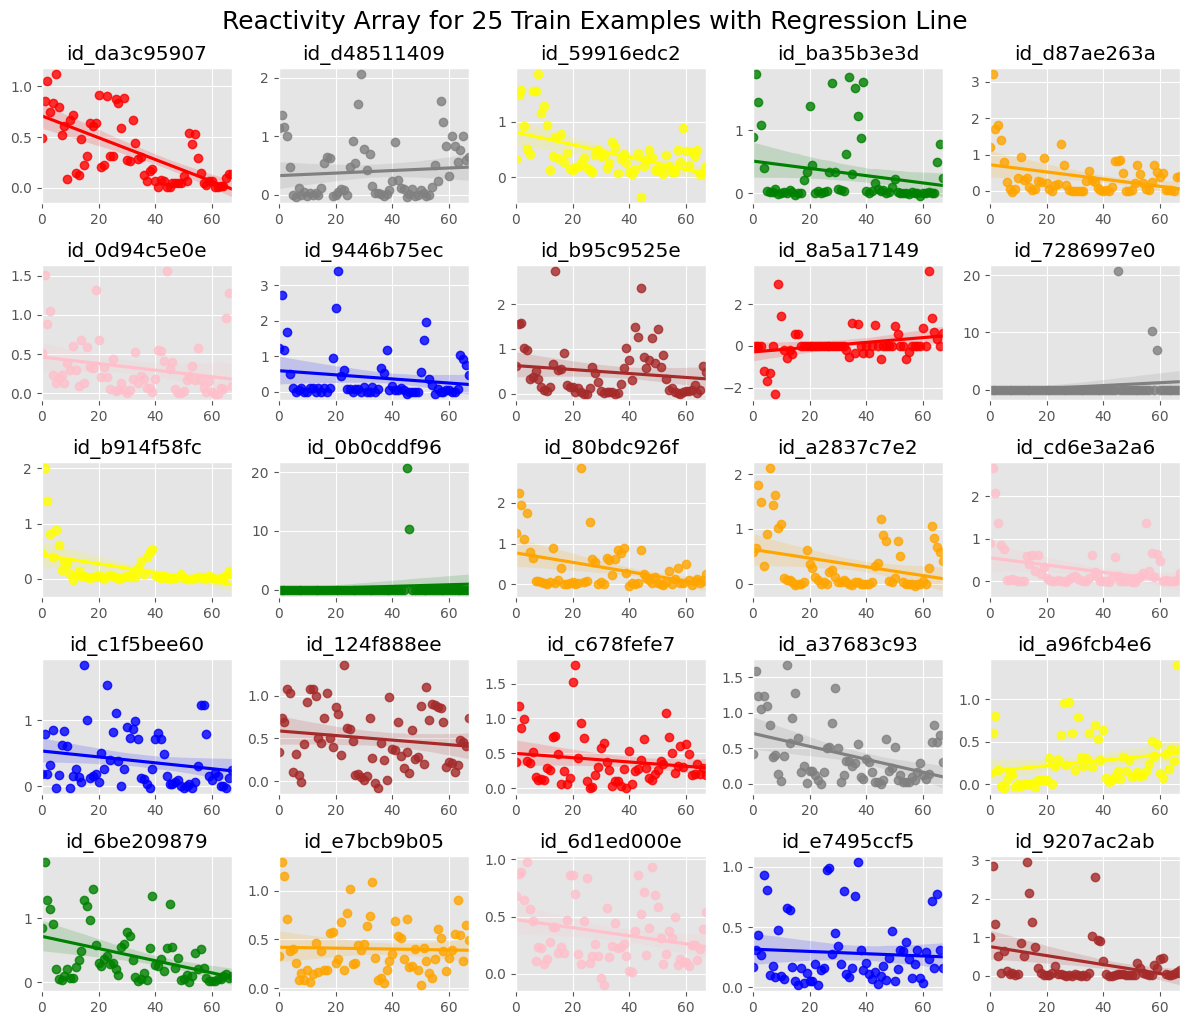

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(12, 10))
axs = axs.flatten()  #axs.shape = 25
i = 0

for row in train.sample(n=25, random_state=42).iterrows():
  myid = row[1]['id']
  reactivity_array = row[1][REACTIVITY_COLS].values # 68 values
  
  #reactivity_array = np.nan_to_num(reactivity_array)
  reactivity_array = np.array(reactivity_array, dtype=float)
 
  sns.regplot(x=np.array(range(68)),
                y=reactivity_array,
                ax=axs[i],
                color=next(color_cycle))

  axs[i].set_title(myid)
  i += 1

fig.suptitle('Reactivity Array for 25 Train Examples with Regression Line',
             fontsize=18,
             y=1.02)
plt.tight_layout()
plt.show()

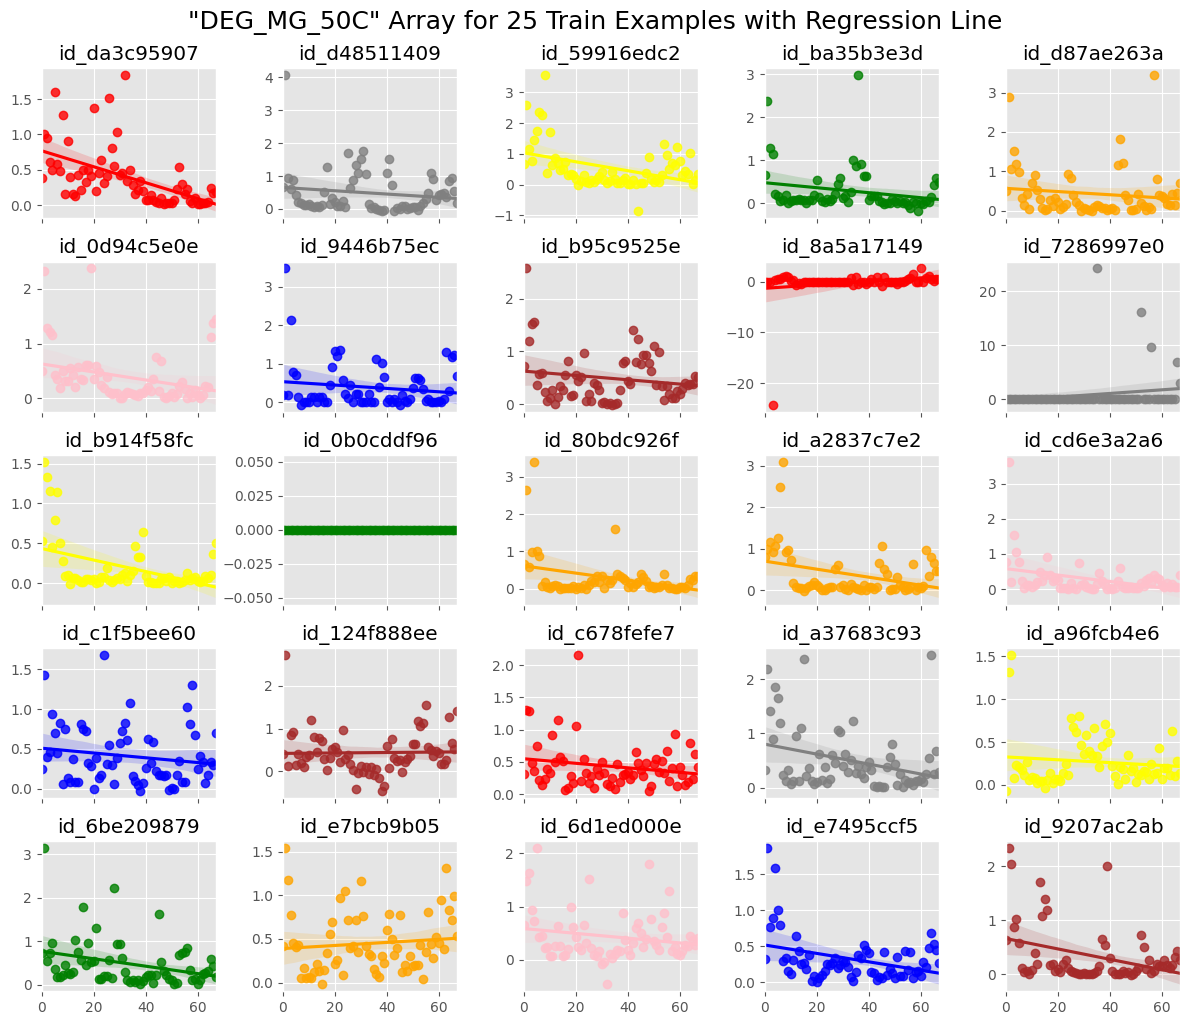

In [ ]:
fig, axs = plt.subplots(5, 5,
                        figsize=(12, 10),
                        sharex=True)
axs = axs.flatten()
i = 0
for row in train.sample(25, random_state=42).iterrows():
    myid = row[1]['id']
    reactivity_array = row[1][DEG_MG_50C_COLS].values
    reactivity_array = np.array(reactivity_array, dtype=float)
    sns.regplot(x=np.array(range(68)).reshape(-1, 1),
                y=reactivity_array,
                ax=axs[i],
                color=next(color_cycle))
    axs[i].set_title(myid)
    i += 1
fig.suptitle('"DEG_MG_50C" Array for 25 Train Examples with Regression Line',
             fontsize=18,
             y=1.02)
plt.tight_layout()
plt.show()


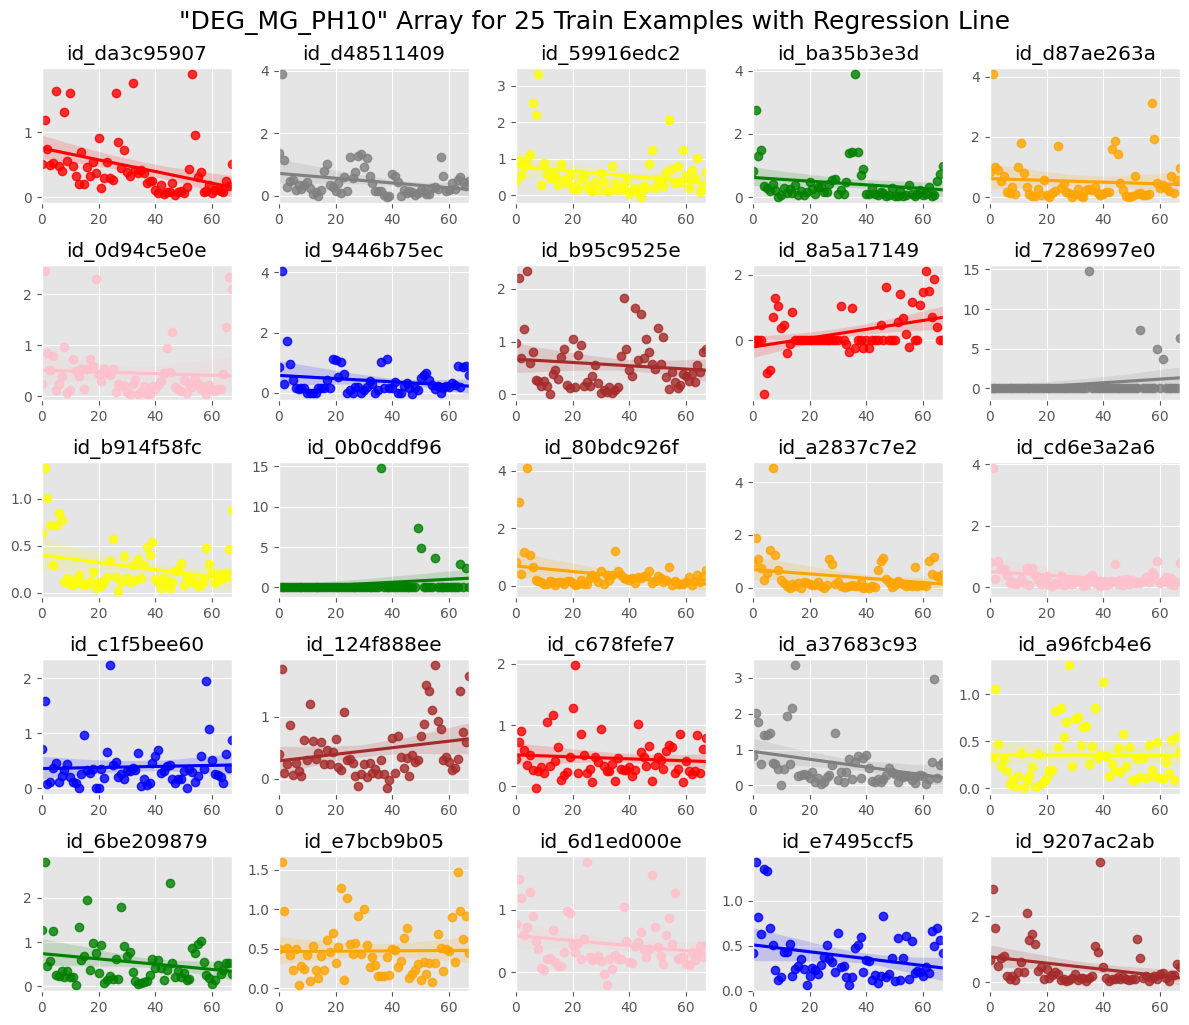

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(12, 10))
axs = axs.flatten()
i = 0
for row in train.sample(25, random_state=42).iterrows():
    myid = row[1]['id']
    reactivity_array = row[1][DEG_MG_PH10_COLS].values
    reactivity_array = np.array(reactivity_array, dtype=float)
    sns.regplot(x=np.array(range(68)).reshape(-1, 1),
                y=reactivity_array,
                ax=axs[i],
                color=next(color_cycle))
    axs[i].set_title(myid)
    i += 1
fig.suptitle('"DEG_MG_PH10" Array for 25 Train Examples with Regression Line',
             fontsize=18,
             y=1.02)
plt.tight_layout()
plt.show()

### Better LightGBM Model

In [ ]:
import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pylab as plt

def expand_columns(df):
    df = df.copy()
    df = df.drop('index', axis=1)
    max_seq_length = df['seq_length'].max()
    SEQUENCE_COLS = []; STRUCTURE_COLS = []; PRED_LOOP_TYPE_COLS = []
    for s in range(130):
        df[f'sequence_{s}'] = df['sequence'].str[s]
        df[f'structure_{s}'] = df['structure'].str[s]
        df[f'predicted_loop_type_{s}'] = df['predicted_loop_type'].str[s]
        SEQUENCE_COLS.append(f'sequence_{s}')
        STRUCTURE_COLS.append(f'structure_{s}')
    return df, SEQUENCE_COLS, STRUCTURE_COLS

def parse_sample_submission(ss):
    ss = ss.copy()
    ss['id'] = ss['id_seqpos'].str.split('_', expand=True)[1]
    ss['seqpos'] = ss['id_seqpos'].str.split('_', expand=True)[2].astype('int')
    return ss

In [ ]:
def get_train_long(train):
    dfs = []

    def pad(feat, tolen):
        padded = np.pad(feat,
                        (0, tolen-len(feat)),
                        mode='constant',
                        constant_values=np.nan)
        return padded

    for d in tqdm(train.itertuples(), total=len(train)):
        print('d=', d)
        sequence = [s for s in d[3]]
        seq_len = len(sequence)
        structure = [s for s in d[4]]
        predicted_loop_type = [s for s in d[5]]
        reactivity_error = pad([s for s in d[10]], seq_len)
        deg_error_Mg_pH10 = pad([s for s in d[11]], seq_len)
        deg_error_pH10 = pad([s for s in d[12]], seq_len)
        deg_error_Mg_50C = pad([s for s in d[13]], seq_len)
        deg_error_50C = pad([s for s in d[14]], seq_len)

        reactivity = pad([s for s in d[15]], seq_len)
        deg_Mg_pH10 = pad([s for s in d[16]], seq_len)
        deg_pH10 = pad([s for s in d[17]], seq_len)
        deg_Mg_50C = pad([s for s in d[18]], seq_len)
        deg_50C = pad([s for s in d[10]], seq_len)
        myid = [d[2]] * len(sequence)
        seqpos = [c for c in range(len(sequence))]
        dfs.append(pd.DataFrame(np.array([myid,
                                          seqpos,
                                          sequence,
                                          structure,
                                          predicted_loop_type,
                                          reactivity_error,
                                          deg_error_Mg_pH10,
                                          deg_error_pH10,
                                          deg_error_Mg_50C,
                                          deg_error_50C,
                                          reactivity,
                                          deg_Mg_pH10,
                                          deg_pH10,
                                          deg_Mg_50C,
                                         ]).T))
    train_long = pd.concat(dfs)

    train_long.columns=['id',
               'seqpos',
               'sequence',
               'structure',
               'predicted_loop_type',
               'reactivity_error',
               'deg_error_Mg_pH10',
               'deg_error_pH10',
               'deg_error_Mg_50C',
               'deg_error_50C',
               'reactivity',
               'deg_Mg_pH10',
               'deg_pH10',
               'deg_Mg_50C']

    return train_long


def get_test_long(test):
    dfs = []

    def pad(feat, tolen):
        padded = np.pad(feat,
                        (0, tolen-len(feat)),
                        mode='constant',
                        constant_values=np.nan)
        return padded

    for d in tqdm(test.itertuples(), total=len(test)):
        sequence = [s for s in d[3]]
        seq_len = len(sequence)
        structure = [s for s in d[4]]
        predicted_loop_type = [s for s in d[5]]
        myid = [d[2]] * len(sequence)
        seqpos = [c for c in range(len(sequence))]
        dfs.append(pd.DataFrame(np.array([myid,
                                          seqpos,
                                          sequence,
                                          structure,
                                          predicted_loop_type,
                                         ]).T))
    test_long = pd.concat(dfs)

    test_long.columns=['id',
               'seqpos',
               'sequence',
               'structure',
               'predicted_loop_type']

    return test_long

def add_long_features(df):
    df = df.copy()
    df['seqpos'] = df['seqpos'].astype('int')
    df = df.merge(df.query('seqpos <= 106') \
                    .groupby('id')['sequence'] \
                      .value_counts() \
                      .unstack() \
                      .reset_index(),
             how='left',
             on=['id'],
             validate='m:1'
            )
    
    df = df.merge(df.query('seqpos <= 106') \
                  .groupby('id')['structure'] \
                      .value_counts() \
                      .unstack() \
                      .reset_index(),
             how='left',
             on=['id'],
             validate='m:1'
            )

    df = df.merge(df.query('seqpos <= 106') \
                  .groupby('id')['predicted_loop_type'] \
                      .value_counts() \
                      .unstack() \
                      .reset_index(),
             how='left',
             on=['id'],
             validate='m:1'
            )
    for shift in [-5, -4, -3, -2 -1, 1, 2, 3, 4, 5]:
        for f in ['sequence','structure','predicted_loop_type']:
            df[f'{f}_shift{shift}'] = df.groupby('id')[f].shift(shift)
    return df

In [ ]:
def make_feature_types(df, features):
    df = df.copy()
    df = df.replace('nan', np.nan)
    for f in features:
        try:
            df[f] = pd.to_numeric(df[f])
        except ValueError:
            df[f] = df[f].astype('category')
    return df


==== Running for target reactivity ====
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's l2: 0.352493
Early stopping, best iteration is:
[1292]	valid_0's l2: 0.351883


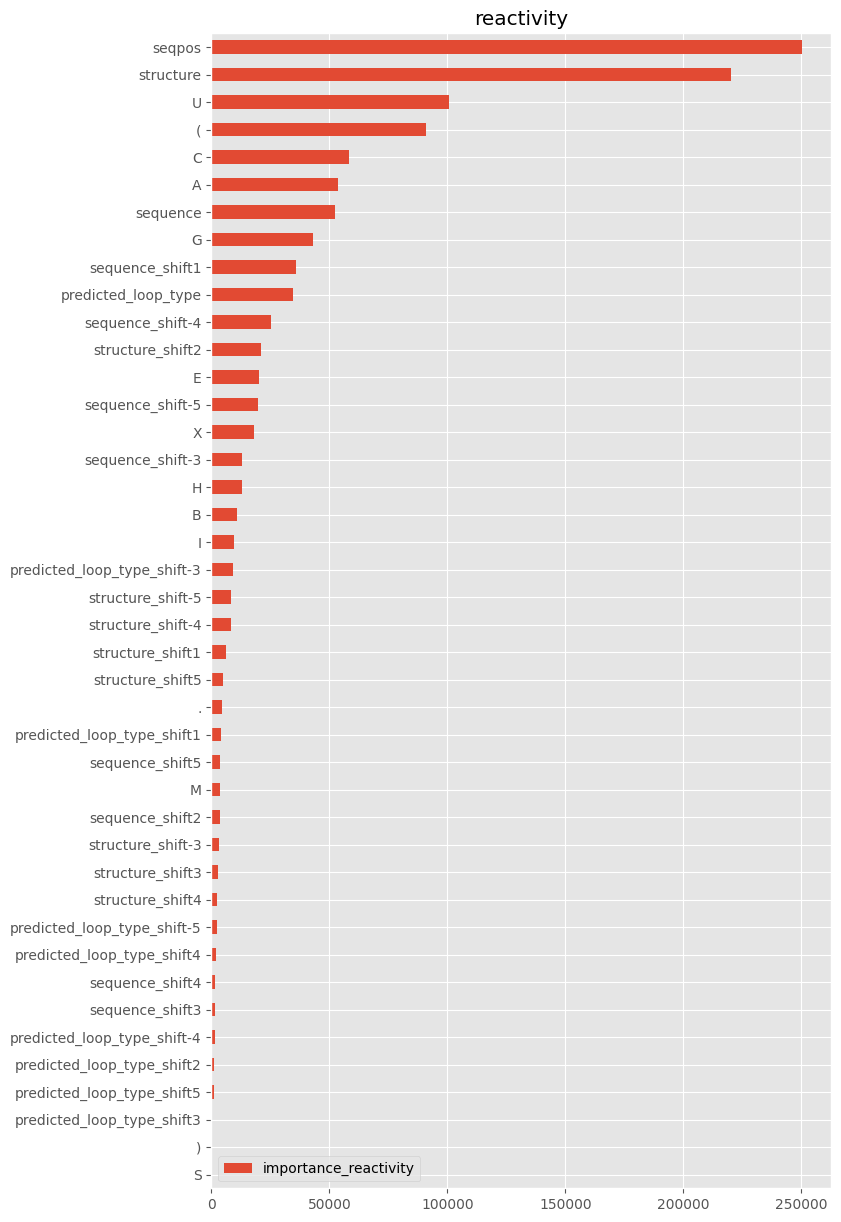

==== Running for target deg_Mg_pH10 ====
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's l2: 0.348583
[2000]	valid_0's l2: 0.343668
[3000]	valid_0's l2: 0.342247
[4000]	valid_0's l2: 0.341118
[5000]	valid_0's l2: 0.340309
[6000]	valid_0's l2: 0.33956
[7000]	valid_0's l2: 0.339245
[8000]	valid_0's l2: 0.339048
Early stopping, best iteration is:
[7916]	valid_0's l2: 0.338982


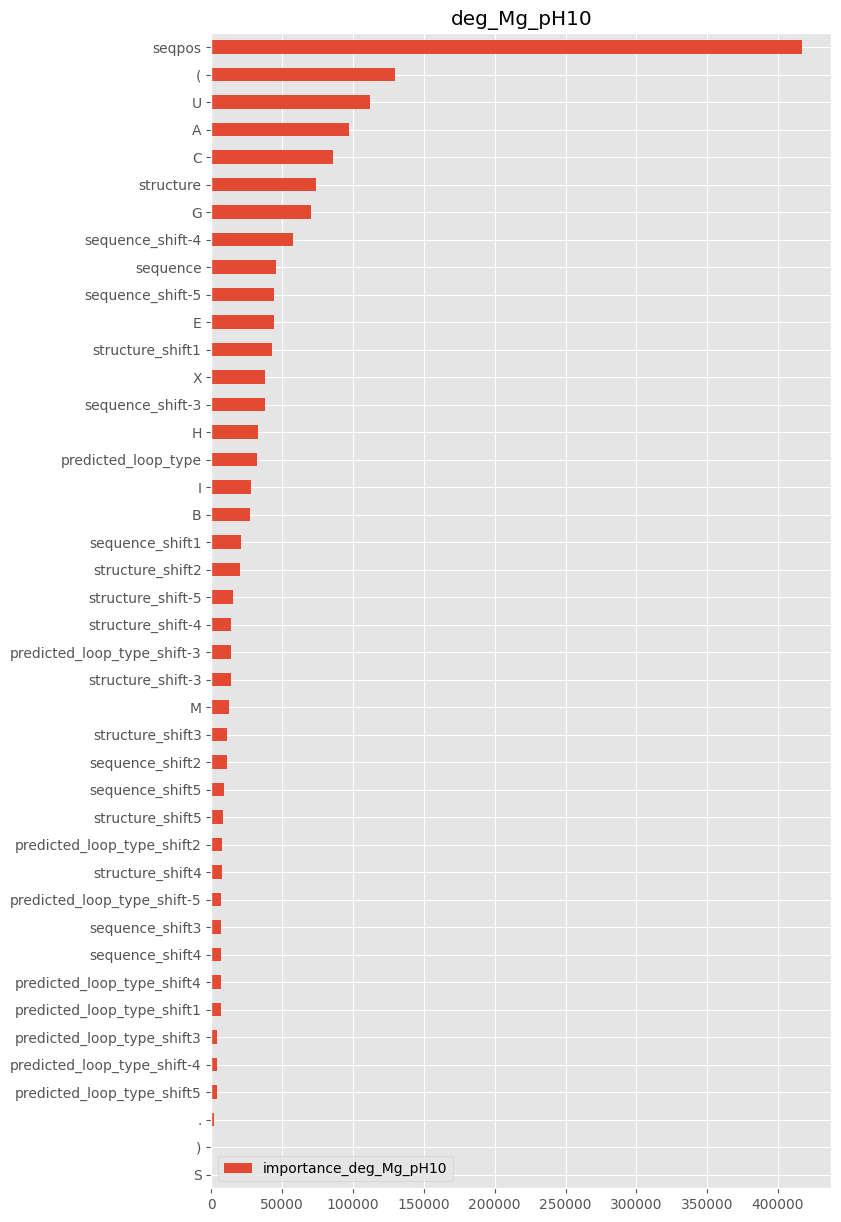

==== Running for target deg_Mg_50C ====
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's l2: 0.564836
Early stopping, best iteration is:
[753]	valid_0's l2: 0.564313


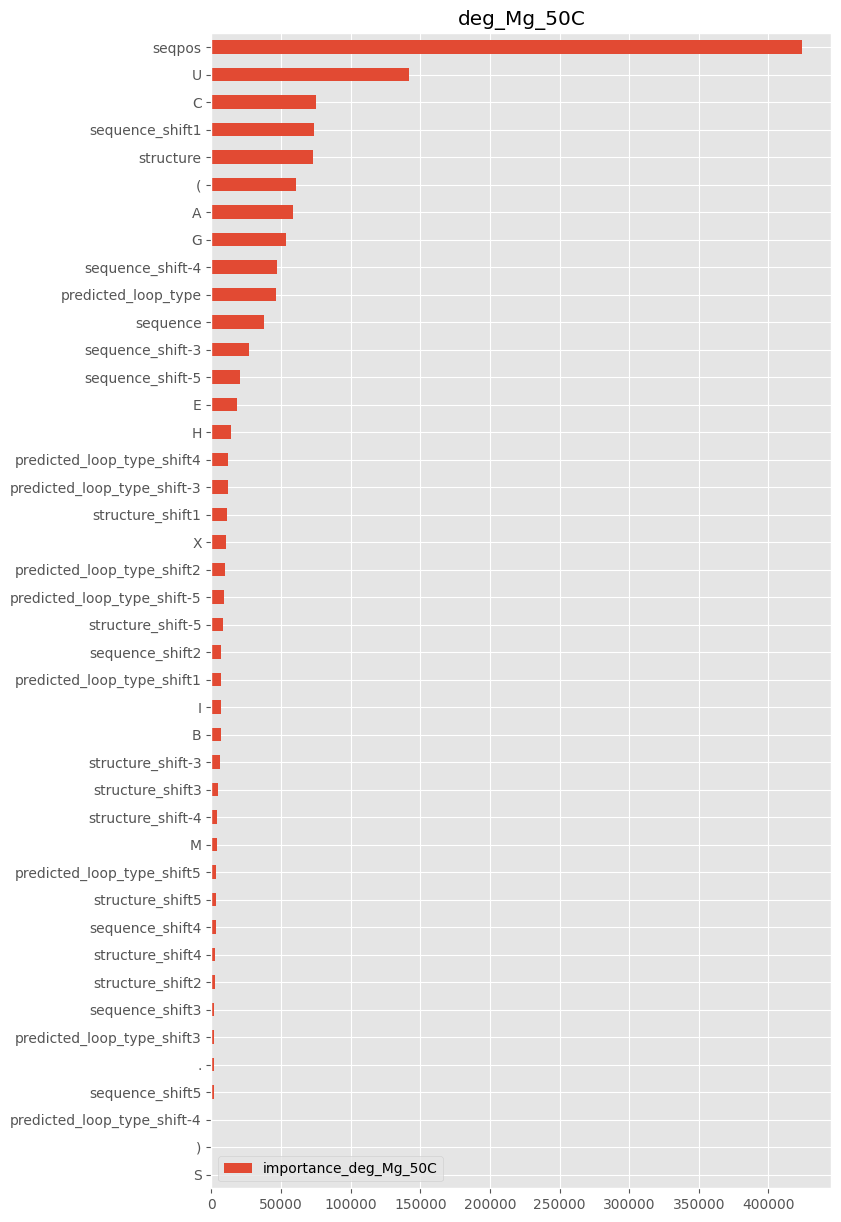

In [ ]:
train = pd.read_json('/content/drive/MyDrive/Dayeeta_Project/train.json', lines=True)
test = pd.read_json('/content/drive/MyDrive/Dayeeta_Project/test.json', lines=True)
ss = pd.read_csv('/content/drive/MyDrive/Dayeeta_Project/sample_submission.csv')

train_expanded, SEQUENCE_COLS, STRUCTURE_COLS = expand_columns(train)
test_expanded, SEQUENCE_COLS, STRUCTURE_COLS = expand_columns(test)
ss = parse_sample_submission(ss)

train_long = get_train_long(train)
test_long = get_test_long(test)

train_long = add_long_features(train_long)
test_long = add_long_features(test_long)

FEATURES = ['seqpos',
            'sequence',
            'structure',
            'predicted_loop_type',
            'A', 'C', 'G', 'U', '(', ')', '.', 'B', 'E',
            'H', 'I', 'M', 'S', 'X',
            'sequence_shift-5', 'structure_shift-5',
            'predicted_loop_type_shift-5', 'sequence_shift-4', 'structure_shift-4',
            'predicted_loop_type_shift-4', 'sequence_shift-3', 'structure_shift-3',
            'predicted_loop_type_shift-3', 'sequence_shift1', 'structure_shift1',
            'predicted_loop_type_shift1', 'sequence_shift2', 'structure_shift2',
            'predicted_loop_type_shift2', 'sequence_shift3', 'structure_shift3',
            'predicted_loop_type_shift3', 'sequence_shift4', 'structure_shift4',
            'predicted_loop_type_shift4', 'sequence_shift5', 'structure_shift5',
            'predicted_loop_type_shift5']

train_long = make_feature_types(train_long, FEATURES)
test_long = make_feature_types(test_long, FEATURES)

train_ids, val_ids = train_test_split(train['id'].unique())

TARGETS = ['reactivity','deg_Mg_pH10','deg_Mg_50C']
fis = []
for t in TARGETS:
    print(f'==== Running for target {t} ====')
    X_train = train_long.dropna(subset=[t]).loc[train_long['id'].isin(train_ids)][FEATURES].copy()
    y_train = train_long.dropna(subset=[t]).loc[train_long['id'].isin(train_ids)][t].copy()
    X_val = train_long.dropna(subset=[t]).loc[train_long['id'].isin(val_ids)][FEATURES].copy()
    y_val = train_long.dropna(subset=[t]).loc[train_long['id'].isin(val_ids)][t].copy()
    X_test = test_long[FEATURES].copy()
    y_train = pd.to_numeric(y_train)
    y_val = pd.to_numeric(y_val)
    
    reg = lgb.LGBMRegressor(n_estimators=10000,
                            learning_rate=0.01,
                            importance_type='gain')
    reg.fit(X_train, y_train,
            eval_set=(X_val, y_val),
           verbose=1000,
           early_stopping_rounds=500)

    fi_df = pd.DataFrame(index=FEATURES, 
                 data=reg.feature_importances_,
                 columns=[f'importance_{t}'])
    
    fi_df.sort_values(f'importance_{t}') \
        .plot(kind='barh', figsize=(8, 15), title=t)
    plt.show()
    fis.append(fi_df)
    
    test_long[f'{t}_pred'] = reg.predict(X_test)

### Create Submission

In [ ]:
test_long['id_seqpos'] = test_long['id'] + '_' + test_long['seqpos'].astype('str')

test_long['deg_pH10'] = 0
test_long['deg_50C'] = 0
test_long = test_long.rename(columns={'reactivity_pred':'reactivity',
                          'deg_Mg_pH10_pred': 'deg_Mg_pH10',
                          'deg_Mg_50C_pred': 'deg_Mg_50C'})

ss = pd.read_csv('/content/drive/MyDrive/Dayeeta_Project/sample_submission.csv')
assert test_long[ss.columns].shape == ss.shape

test_long[ss.columns].to_csv('submission.csv', index=False)

### Plot Distribution of predictions vs. Training

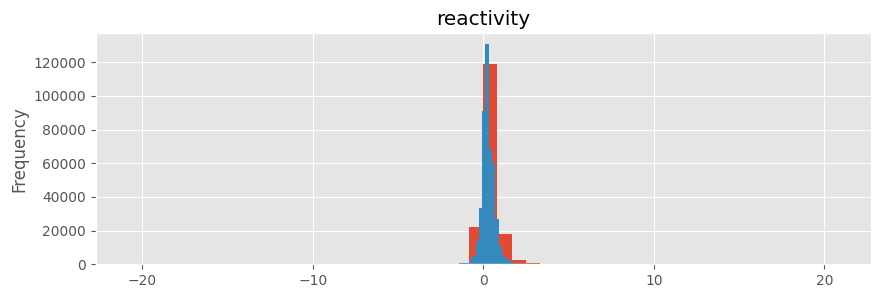

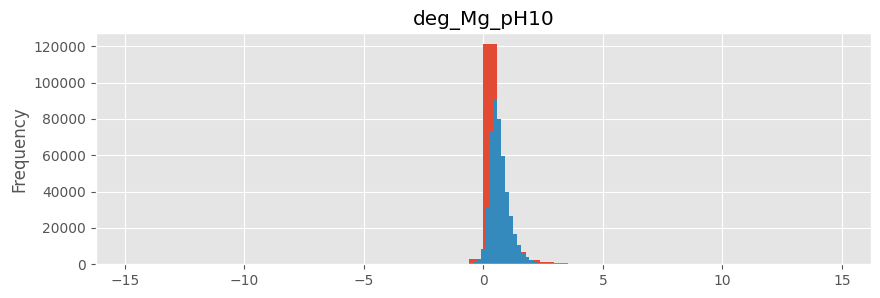

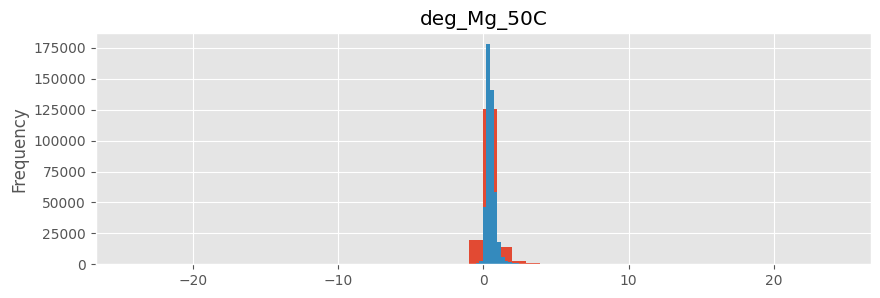

In [ ]:
for t in TARGETS:
    train_long[t].dropna().astype('float').plot(kind='hist', bins=50, figsize=(10, 3), title=t)
    test_long[t].plot(kind='hist', bins=50, figsize=(10, 3), title=t)
    plt.show()